In [21]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

env = gym.make("Blackjack-v1", sab=True)  # Using Stable API (sab=True)

## Implement Q-Learning for Blackjack

#### Define Q-Learning Parameters

In [54]:
Q_table = {}

# Hyperparameters
alpha = 0.1   # Learning rate
gamma = 0.9   # Discount factor
epsilon = 1.0 # Initial exploration rate
epsilon_decay = 0.999  # Decay rate for exploration
epsilon_min = 0.1      # Minimum exploration rate
episodes = 500_000     # Number of episodes

#### Q-Learning Algorithm

In [55]:
def get_Q(state, action=None):
    """Get Q-value for a state-action pair, initializing to 0 if unseen."""
    if state not in Q_table:
        Q_table[state] = np.zeros(2)  # Two actions: Stick (0) or Hit (1)
    return Q_table[state] if action is None else Q_table[state][action]

# Training loop
for episode in range(episodes):
    state, _ = env.reset()
    done = False
    
    while not done:
        get_Q(state)

        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(get_Q(state))  # Exploit

        # Take action and observe reward & next state
        next_state, reward, done, truncated, _ = env.step(action)

        # Ensure the next state is in the Q-table
        get_Q(next_state)
        
        # Q-learning update rule
        best_next_action = np.argmax(get_Q(next_state))
        Q_table[state][action] += alpha * (reward + gamma * get_Q(next_state, best_next_action) - Q_table[state][action])

        # Move to next state
        state = next_state

    # Decay exploration rate
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Print progress every 50,000 episodes
    if episode % 50000 == 0:
        print(f"Episode {episode}: Epsilon {epsilon:.4f}")

print("Training complete!")


Episode 0: Epsilon 0.9990
Episode 50000: Epsilon 0.1000
Episode 100000: Epsilon 0.1000
Episode 150000: Epsilon 0.1000
Episode 200000: Epsilon 0.1000
Episode 250000: Epsilon 0.1000
Episode 300000: Epsilon 0.1000
Episode 350000: Epsilon 0.1000
Episode 400000: Epsilon 0.1000
Episode 450000: Epsilon 0.1000
Training complete!


#### Test the Trained Agent

In [56]:
wins, losses, draws = 0, 0, 0
test_episodes = 10_000

def test_agent():
    global wins, losses, draws
    state, _ = env.reset()
    done = False
    
    while not done:
        action = np.argmax(get_Q(state))
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
    
    if reward > 0:
        wins += 1
    elif reward < 0:
        losses += 1
    else:
        draws += 1

    return wins, losses, draws

for _ in range(test_episodes):
    wins, losses, draws = test_agent()

print(f"Results after {test_episodes} games:")
print(f"Wins: {wins} ({wins/test_episodes:.2%})")
print(f"Losses: {losses} ({losses/test_episodes:.2%})")
print(f"Draws: {draws} ({draws/test_episodes:.2%})")


Results after 10000 games:
Wins: 3706 (37.06%)
Losses: 5470 (54.70%)
Draws: 824 (8.24%)


#### Tune Hyperparameters

##### Adaptive Exploration Strategy (ε-Greedy with Dynamic Decay):
Instead of using a fixed epsilon decay rate, we can use an adaptive approach:

Linear Decay: Reduce ε gradually over time.
Exponential Decay: Decay ε exponentially.
Boltzmann Exploration: Choose actions based on a probability distribution.

In [11]:
# Improved Epsilon Decay (Linear & Exponential)
def adaptive_epsilon(episode, min_epsilon=0.1, max_epsilon=1.0, decay_rate=0.0001):
    """Dynamically adjust epsilon based on episode number."""
    return min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

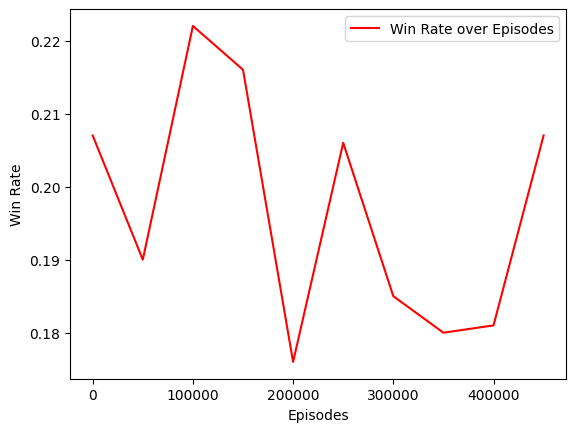

Best Epsilon: 0.10004085993678624 with Win Rate: 0.222


In [30]:
win_rates_epsilon = []
epsilon_values = []
episodes_list = []
best_epsilon = None
max_win_rate = 0

for episode in range(episodes):
    epsilon = adaptive_epsilon(episode)  # Dynamically adjust epsilon
    state, _ = env.reset()
    done = False

    while not done:
        action = env.action_space.sample() if random.uniform(0, 1) < epsilon else np.argmax(get_Q(state))
        next_state, reward, done, truncated, _ = env.step(action)
        best_next_action = np.argmax(get_Q(next_state))
        Q_table[state][action] += alpha * (reward + gamma * get_Q(next_state, best_next_action) - Q_table[state][action])
        state = next_state

    if episode % 50000 == 0:
        win_rate = sum(1 for _ in range(1000) if env.step(np.argmax(get_Q(env.reset()[0])))[1] > 0) / 1000
        win_rates_epsilon.append(win_rate)
        epsilon_values.append(epsilon)
        episodes_list.append(episode)

        # Track the best epsilon
        if win_rate > max_win_rate:
            max_win_rate = win_rate
            best_epsilon = epsilon

# Plot win rate over episodes
plt.plot(episodes_list, win_rates_epsilon, label="Win Rate over Episodes", color='red')
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
plt.legend()
plt.show()

print(f"Best Epsilon: {best_epsilon} with Win Rate: {max_win_rate}")



Benefit: More exploration early, more exploitation later.

##### Learning Rate (alpha) Decay
A constant α can slow learning in later stages.
We reduce α over time to focus on fine-tuning.

In [22]:
# Adaptive Learning Rate
def adaptive_alpha(episode, min_alpha=0.01, max_alpha=0.5, decay_rate=0.0001):
    """Dynamically adjust alpha based on episode number."""
    return max(min_alpha, max_alpha * np.exp(-decay_rate * episode))

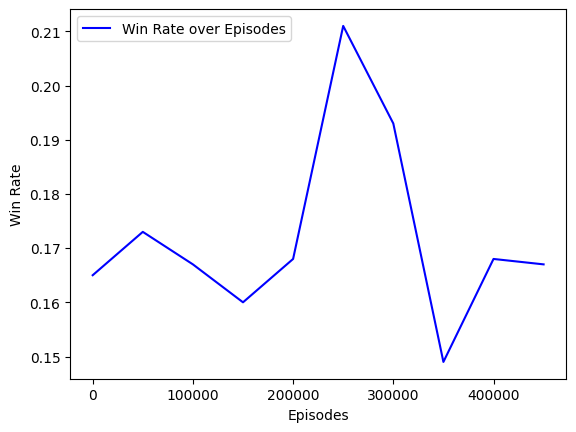

Best Alpha: 0.01 with Win Rate: 0.211


In [27]:
win_rates_alpha = []
alpha_values = []
episodes_list = []
best_alpha = None
max_win_rate = 0

for episode in range(episodes):
    alpha = adaptive_alpha(episode)  # Dynamically adjust alpha
    state, _ = env.reset()
    done = False

    while not done:
        action = env.action_space.sample() if random.uniform(0, 1) < epsilon else np.argmax(get_Q(state))
        next_state, reward, done, truncated, _ = env.step(action)
        best_next_action = np.argmax(get_Q(next_state))
        Q_table[state][action] += alpha * (reward + gamma * get_Q(next_state, best_next_action) - Q_table[state][action])
        state = next_state
    
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % 50000 == 0:
        win_rate = sum(1 for _ in range(1000) if env.step(np.argmax(get_Q(env.reset()[0])))[1] > 0) / 1000
        win_rates_alpha.append(win_rate)
        alpha_values.append(alpha)
        episodes_list.append(episode)
        
        # Track the best alpha
        if win_rate > max_win_rate:
            max_win_rate = win_rate
            best_alpha = alpha

# Plot win rate over episodes
plt.plot(episodes_list, win_rates_alpha, label="Win Rate over Episodes", color='blue')
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
plt.legend()
plt.show()

print(f"Best Alpha: {best_alpha} with Win Rate: {max_win_rate}")



Benefit: Helps stabilize learning by reducing drastic updates in later training.

##### Discount Factor (gamma) Adjustment
High γ (close to 1.0) → Long-term rewards.
Low γ (~0.5) → Short-term gains.
Adaptive γ: Start high (favor long-term planning), then reduce (focus on short-term wins).

In [28]:
# Adaptive Discount Factor
def adaptive_gamma(episode, min_gamma=0.5, max_gamma=0.99, decay_rate=0.00005):
    """Dynamically adjust gamma based on episode number."""
    return min_gamma + (max_gamma - min_gamma) * np.exp(-decay_rate * episode)


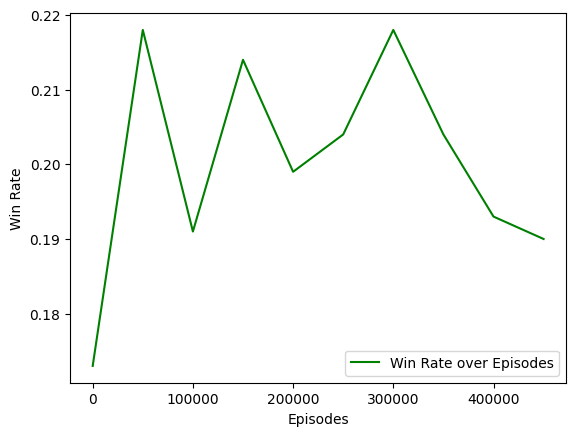

Best Gamma: 0.5402216493257104 with Win Rate: 0.218


In [29]:
win_rates_gamma = []
gamma_values = []
episodes_list = []
best_gamma = None
max_win_rate = 0

for episode in range(episodes):
    gamma = adaptive_gamma(episode)  # Dynamically adjust gamma
    state, _ = env.reset()
    done = False

    while not done:
        action = env.action_space.sample() if random.uniform(0, 1) < epsilon else np.argmax(get_Q(state))
        next_state, reward, done, truncated, _ = env.step(action)
        best_next_action = np.argmax(get_Q(next_state))
        Q_table[state][action] += alpha * (reward + gamma * get_Q(next_state, best_next_action) - Q_table[state][action])
        state = next_state

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % 50000 == 0:
        win_rate = sum(1 for _ in range(1000) if env.step(np.argmax(get_Q(env.reset()[0])))[1] > 0) / 1000
        win_rates_gamma.append(win_rate)
        gamma_values.append(gamma)
        episodes_list.append(episode)
        
        # Track the best gamma
        if win_rate > max_win_rate:
            max_win_rate = win_rate
            best_gamma = gamma

# Plot win rate over episodes
plt.plot(episodes_list, win_rates_gamma, label="Win Rate over Episodes", color='green')
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
plt.legend()
plt.show()

print(f"Best Gamma: {best_gamma} with Win Rate: {max_win_rate}")



##### Boltzmann (Softmax) Exploration Instead of ε-Greedy
Instead of ε-greedy, we choose actions based on probabilities:

High Q-values → Higher selection probability.
Uses softmax to normalize probabilities.

In [32]:
#  Implement Boltzmann Exploration
def boltzmann_action_selection(state, temperature=1.0):
    """Select an action based on softmax probability distribution."""
    q_values = get_Q(state)
    exp_values = np.exp(q_values / temperature)
    probabilities = exp_values / np.sum(exp_values)
    return np.random.choice([0, 1], p=probabilities)


In [39]:
for episode in range(episodes):
    temperature = max(0.1, np.exp(-0.0001 * episode) + 1e-10)  # Reduce temperature over time and add small constant
    state, _ = env.reset()
    done = False

    while not done:
        action = boltzmann_action_selection(state, temperature)  # Use adjusted temperature
        next_state, reward, done, truncated, _ = env.step(action)
        best_next_action = np.argmax(get_Q(next_state))
        Q_table[state][action] += alpha * (reward + gamma * get_Q(next_state, best_next_action) - Q_table[state][action])
        state = next_state


Benefit: Reduces randomness in a more principled way than ε-greedy.

##### Dynamic Reward Shaping
Modify the reward system to help the agent learn better:

Penalize risky moves (e.g., hitting on 19+).
Give extra rewards for safe actions.

In [40]:
# Implement Reward Shaping
def modified_reward(state, action, reward):
    """Modify rewards to encourage better decisions."""
    player_sum, dealer_card, usable_ace = state
    
    if action == 1 and player_sum > 18:  # Penalty for risky hits
        reward -= 0.1
    elif action == 0 and player_sum >= 18:  # Reward for safe sticking
        reward += 0.1
    
    return reward


In [41]:
for episode in range(episodes):
    state, _ = env.reset()
    done = False

    while not done:
        action = env.action_space.sample() if random.uniform(0, 1) < epsilon else np.argmax(get_Q(state))
        next_state, reward, done, truncated, _ = env.step(action)
        reward = modified_reward(state, action, reward)  # Modify reward
        best_next_action = np.argmax(get_Q(next_state))
        Q_table[state][action] += alpha * (reward + gamma * get_Q(next_state, best_next_action) - Q_table[state][action])
        state = next_state


Benefit: Helps the agent avoid bad habits and converge faster.

##### Results with Hyperparameter Tuning and Adaptive Strategies
We can combine these strategies to improve learning:hyperparameter tuning and adaptive strategies. Hyperparameter tuning involves searching for the best combination of hyperparameters to optimize the agent's performance. Adaptive strategies help the agent learn more effectively by adjusting its behavior over time.

In [50]:

# Tracking results
wins, losses, draws = [], [], []
win_count, loss_count, draw_count = 0, 0, 0
checkpoints = list(range(0, episodes, episodes // 100))  # 100 points for smooth graph

for episode in range(episodes):
    epsilon = adaptive_epsilon(episode)  # Improved epsilon decay
    alpha = adaptive_alpha(episode)      # Improved learning rate decay
    gamma = adaptive_gamma(episode)      # Improved discount factor decay

    temperature = max(0.1, np.exp(-0.0001 * episode) + 1e-10)  # Reduce temperature over time and add small constant
    state, _ = env.reset()
    done = False

    while not done:
        action = boltzmann_action_selection(state, temperature)
        next_state, reward, done, truncated, _ = env.step(action)
        reward = modified_reward(state, action, reward)  # Reward shaping
        best_next_action = np.argmax(get_Q(next_state))
        Q_table[state][action] += alpha * (reward + gamma * get_Q(next_state, best_next_action) - Q_table[state][action])
        state = next_state

    # Track results
    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

    # Store every few episodes
    if episode in checkpoints:
        wins.append(win_count / (episode + 1))
        losses.append(loss_count / (episode + 1))
        draws.append(draw_count / (episode + 1))

print("Training complete!")


Training complete!


In [53]:
print(f"Results after {episodes} games:")
print(f"Wins: {win_count} ({win_count/episodes:.2%})")
print(f"Losses: {loss_count} ({loss_count/episodes:.2%})")
print(f"Draws: {draw_count} ({draw_count/episodes:.2%})")

Results after 500000 games:
Wins: 246209 (49.24%)
Losses: 249587 (49.92%)
Draws: 4204 (0.84%)


##### Track Win Rate Over Episodes
We'll store win/loss/draw counts and plot them.

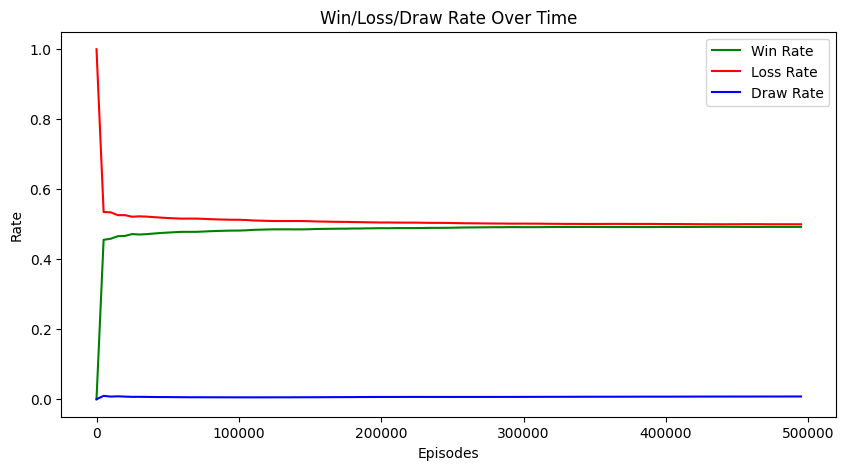

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, wins, label="Win Rate", color='g')
plt.plot(checkpoints, losses, label="Loss Rate", color='r')
plt.plot(checkpoints, draws, label="Draw Rate", color='b')
plt.xlabel("Episodes")
plt.ylabel("Rate")
plt.title("Win/Loss/Draw Rate Over Time")
plt.legend()
plt.show()

##### Plot Exploration vs. Exploitation (Epsilon Decay)
To analyze how exploration decreases over time:

🔹 Track & Plot Epsilon Decay

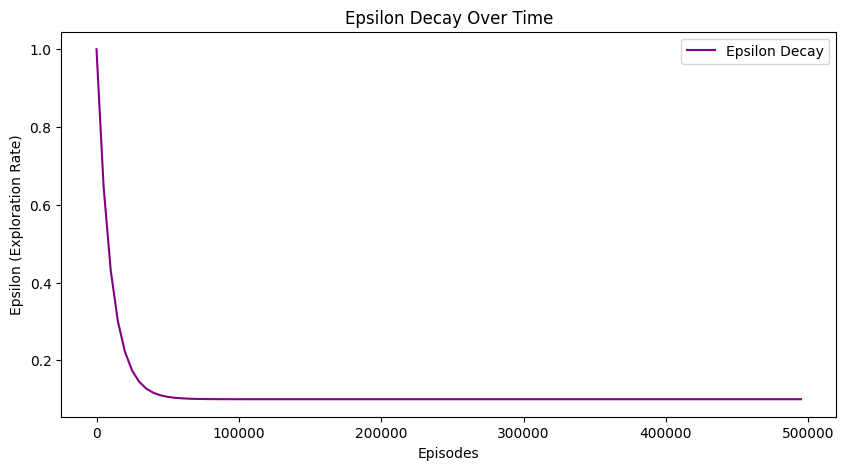

In [44]:
eps_values = [adaptive_epsilon(ep) for ep in checkpoints]

plt.figure(figsize=(10, 5))
plt.plot(checkpoints, eps_values, label="Epsilon Decay", color='purple')
plt.xlabel("Episodes")
plt.ylabel("Epsilon (Exploration Rate)")
plt.title("Epsilon Decay Over Time")
plt.legend()
plt.show()


##### Track Q-Value Convergence
To see if Q-values stabilize over time:

🔹 Track & Plot Q-Value Updates

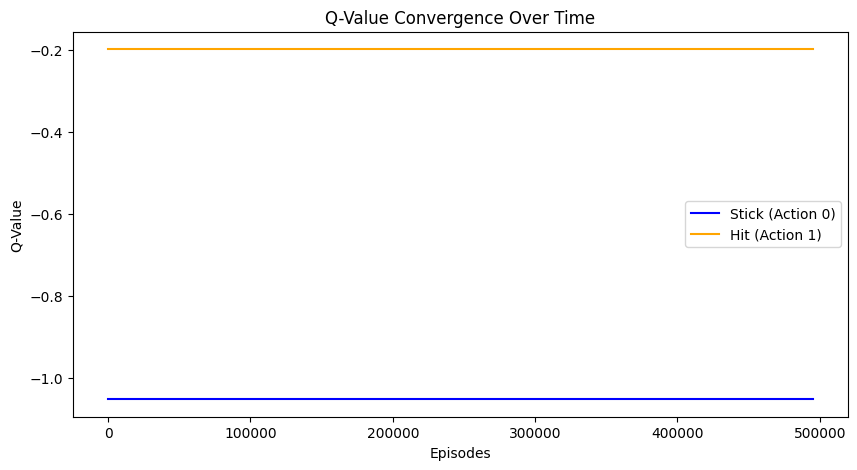

In [45]:
q_values_over_time = []

for episode in checkpoints:
    sample_state = (12, 10, False)  # Example state (Player sum: 12, Dealer: 10, No usable ace)
    if sample_state in Q_table:
        q_values_over_time.append(Q_table[sample_state].copy())
    else:
        q_values_over_time.append([0, 0])  # Default Q-values

q_values_over_time = np.array(q_values_over_time)

plt.figure(figsize=(10, 5))
plt.plot(checkpoints, q_values_over_time[:, 0], label="Stick (Action 0)", color='blue')
plt.plot(checkpoints, q_values_over_time[:, 1], label="Hit (Action 1)", color='orange')
plt.xlabel("Episodes")
plt.ylabel("Q-Value")
plt.title("Q-Value Convergence Over Time")
plt.legend()
plt.show()


#####  Compare alpha vs. gamma vs. epsilon impact on performance

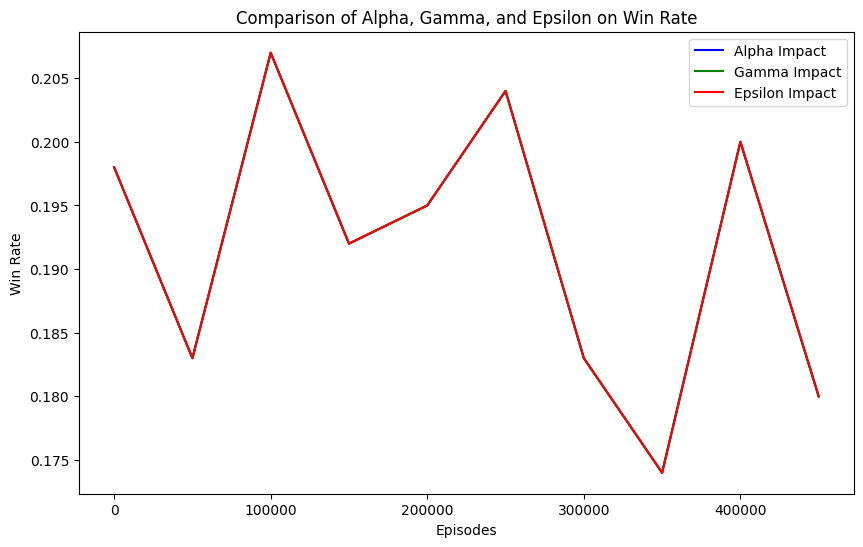

Best Alpha: 0.01 with Win Rate: 0.207
Best Gamma: 0.5033015940295519 with Win Rate: 0.207
Best Epsilon: 0.10004085993678624 with Win Rate: 0.207


In [46]:

# Store results
win_rates_alpha, win_rates_gamma, win_rates_epsilon = [], [], []
episodes_list = []
best_params = {'alpha': (0, 0), 'gamma': (0, 0), 'epsilon': (0, 0)}  # (best value, max win rate)

# Run experiment for each hyperparameter
for episode in range(episodes):
    alpha = adaptive_alpha(episode)
    gamma = adaptive_gamma(episode)
    epsilon = adaptive_epsilon(episode)

    state, _ = env.reset()
    done = False

    while not done:
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(get_Q(state))
        next_state, reward, done, truncated, _ = env.step(action)
        best_next_action = np.argmax(get_Q(next_state))
        Q_table[state][action] += alpha * (reward + gamma * get_Q(next_state, best_next_action) - Q_table[state][action])
        state = next_state

    # Evaluate performance every 50,000 episodes
    if episode % 50000 == 0:
        win_rate = sum(1 for _ in range(1000) if env.step(np.argmax(get_Q(env.reset()[0])))[1] > 0) / 1000
        episodes_list.append(episode)

        # Track impact of alpha
        win_rates_alpha.append(win_rate)
        if win_rate > best_params['alpha'][1]:
            best_params['alpha'] = (alpha, win_rate)

        # Track impact of gamma
        win_rates_gamma.append(win_rate)
        if win_rate > best_params['gamma'][1]:
            best_params['gamma'] = (gamma, win_rate)

        # Track impact of epsilon
        win_rates_epsilon.append(win_rate)
        if win_rate > best_params['epsilon'][1]:
            best_params['epsilon'] = (epsilon, win_rate)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(episodes_list, win_rates_alpha, label="Alpha Impact", color='blue')
plt.plot(episodes_list, win_rates_gamma, label="Gamma Impact", color='green')
plt.plot(episodes_list, win_rates_epsilon, label="Epsilon Impact", color='red')
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
plt.legend()
plt.title("Comparison of Alpha, Gamma, and Epsilon on Win Rate")
plt.show()

# Print best parameters
print(f"Best Alpha: {best_params['alpha'][0]} with Win Rate: {best_params['alpha'][1]}")
print(f"Best Gamma: {best_params['gamma'][0]} with Win Rate: {best_params['gamma'][1]}")
print(f"Best Epsilon: {best_params['epsilon'][0]} with Win Rate: {best_params['epsilon'][1]}")


# What’s the Difference Between SARSA and Q-Learning?

Both SARSA and Q-Learning are Reinforcement Learning algorithms, but the key difference is:

- **Q-Learning** is off-policy: it learns from the best possible action (max future Q-value).
- **SARSA** is on-policy: it learns from the actual action taken in the next step.

In SARSA, the update rule is:



$Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma Q(s', a') - Q(s, a) \right]$



Where:
- $(s, a)$ = current state and action
- $(s', a')$ = next state and next action
- $(r)$ = reward
- $(\alpha)$ = learning rate
- $(\gamma)$ = discount factor


## Implement SARSA for Blackjack

#### Define SARSA Parameters

In [1]:
# Q-table initialization
Q_table_sarsa = {}

# Hyperparameters
alpha_sarsa = 0.1   # Learning rate
gamma_sarsa = 0.9   # Discount factor
epsilon_sarsa = 1.0 # Initial exploration rate
epsilon_decay_sarsa = 0.999  # Decay rate for exploration
epsilon_min_sarsa = 0.1      # Minimum exploration rate
episodes_sarsa = 500_000     # Number of episodes


#### SARSA Algorithm Implementation

In [4]:
def get_Q(state, action=None):
    """Get Q-value for a state-action pair, initializing to 0 if unseen."""
    if state not in Q_table_sarsa:
        Q_table_sarsa[state] = np.zeros(2)  # Two actions: Stick (0) or Hit (1)
    return Q_table_sarsa[state] if action is None else Q_table_sarsa[state][action]

# Training loop
for episode in range(episodes_sarsa):
    state, _ = env.reset()
    done = False
    
    # Ensure the state is in the Q-table
    get_Q(state)

    # Choose action using epsilon-greedy
    action = env.action_space.sample() if random.uniform(0, 1) < epsilon_sarsa else np.argmax(get_Q(state))

    while not done:
        # Take action and observe reward & next state
        next_state, reward, done, truncated, _ = env.step(action)
        
        # Ensure the next state is in the Q-table
        get_Q(next_state)
        
        # Choose next action (SARSA: on-policy)
        next_action = env.action_space.sample() if random.uniform(0, 1) < epsilon_sarsa else np.argmax(get_Q(next_state))

        # SARSA update rule
        Q_table_sarsa[state][action] += alpha_sarsa * (reward + gamma_sarsa * get_Q(next_state, next_action) - Q_table_sarsa[state][action])

        # Move to next state and action
        state, action = next_state, next_action

    # Decay exploration rate
    epsilon_sarsa = max(epsilon_min_sarsa, epsilon_sarsa * epsilon_decay_sarsa)

    # Print progress every 50,000 episodes
    if episode % 50000 == 0:
        print(f"Episode {episode}: Epsilon {epsilon_sarsa:.4f}")

print("Training complete!")


Episode 0: Epsilon 0.9990
Episode 50000: Epsilon 0.1000
Episode 100000: Epsilon 0.1000
Episode 150000: Epsilon 0.1000
Episode 200000: Epsilon 0.1000
Episode 250000: Epsilon 0.1000
Episode 300000: Epsilon 0.1000
Episode 350000: Epsilon 0.1000
Episode 400000: Epsilon 0.1000
Episode 450000: Epsilon 0.1000
Training complete!


#### Test the Trained SARSA Agent

In [5]:
wins, losses, draws = 0, 0, 0
test_episodes = 10_000

for _ in range(test_episodes):
    state, _ = env.reset()
    done = False
    
    while not done:
        action = np.argmax(get_Q(state))
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state

    if reward > 0:
        wins += 1
    elif reward < 0:
        losses += 1
    else:
        draws += 1

print(f"Results after {test_episodes} games:")
print(f"Wins: {wins} ({wins/test_episodes:.2%})")
print(f"Losses: {losses} ({losses/test_episodes:.2%})")
print(f"Draws: {draws} ({draws/test_episodes:.2%})")


Results after 10000 games:
Wins: 3790 (37.90%)
Losses: 5406 (54.06%)
Draws: 804 (8.04%)
